## Predicting consumer behaviour 

Over the past few years businesses have come to appreciate the value social media has on their growth. Is it possible to predict whether or not a purchase will be made based on the comments on a social media post?

For instance a clothing and accesories online business that advertises its products on Instagram.

### Data Preparation

In [275]:
#Import the necesary libraries for data access and manipulation
import numpy as np
import pandas as pd

#Import the data cleaning library
import re

#Import the visualization libraries
import matplotlib.pyplot as plt 
import seaborn as sns
    
# for Stemming propose  
from nltk.stem.porter import PorterStemmer 

#Text Processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

# Import the metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve,auc

#Import warnings
import warnings 

# configuration settings
%matplotlib inline
warnings.filterwarnings("ignore")

In [276]:
#Load the data and preview
comments_df = pd.read_csv('post_comments.csv')
comments_df.sample(10)

,Comment_ID,User_ID,Date,Likes,Comment,Purchase
79,80,USID064,04/14/20 09:22:00,0,@user ??,0
45,46,USID029,10/02/20 11:22:44,0,@user there goes your traveling bag usiseme si...,0
54,55,USID032,30/01/20 09:47:40,1,How much for this ??one,1
52,53,USID043,13/02/20 14:56:26,1,@user can i get one,1
60,61,USID045,29/01/20 20:26:16,2,Goodbag,0
39,40,USID057,22/02/20 11:38:11,0,Where's the shop at?,0
15,16,USID004,13/04/20 08:24:18,0,You still have this?,1
67,68,USID039,24/02/20 02:33:46,0,How much,0
2,3,USID031,13/04/20 08:05:29,1,How much is the belt ?,0
68,69,USID074,04/20/20 08:26:00,1,"??????Ebu leta hizi, kwanza jeggings",0


In [277]:
comments_df.shape

(87, 6)

In [278]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 6 columns):
Comment_ID    87 non-null int64
User_ID       87 non-null object
Date          87 non-null object
Likes         87 non-null int64
Comment       87 non-null object
Purchase      87 non-null int64
dtypes: int64(3), object(3)
memory usage: 4.2+ KB


In [279]:
comments_df.isnull().any()

Comment_ID    False
User_ID       False
Date          False
Likes         False
Comment       False
Purchase      False
dtype: bool

In [280]:
comments_df.Purchase.value_counts()

0    56
1    31
Name: Purchase, dtype: int64

In [281]:
comments_df.describe(include = 'all')

,Comment_ID,User_ID,Date,Likes,Comment,Purchase
count,87.000000,87,87,87.000000,87,87.000000
unique,NaN,68,87,NaN,67,NaN
top,NaN,USID021,04/20/20 10:27:00,NaN,How much,NaN
freq,NaN,3,1,NaN,12,NaN
mean,44.000000,NaN,NaN,0.218391,NaN,0.356322
std,25.258662,NaN,NaN,0.468180,NaN,0.481688
min,1.000000,NaN,NaN,0.000000,NaN,0.000000
25%,22.500000,NaN,NaN,0.000000,NaN,0.000000
50%,44.000000,NaN,NaN,0.000000,NaN,0.000000
75%,65.500000,NaN,NaN,0.000000,NaN,1.000000


#### Exploratory Data Analysis

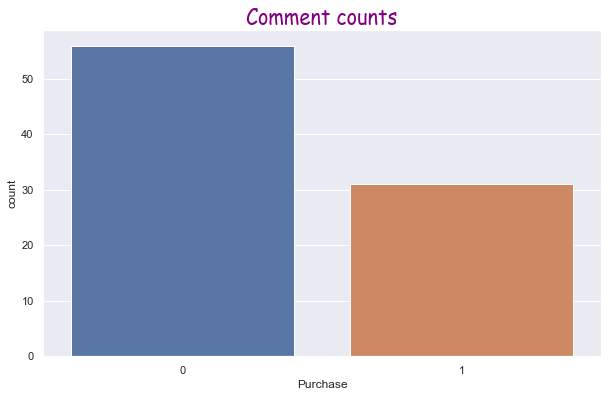

In [282]:
#Plotting out the classification as either purchased or not purchased
# 0 representing no purchase while 1 represents purchase

plt.figure(figsize=(10,6))
plt.title('Comment counts',loc ='center',pad=None,
         fontdict={'fontname':'Comic Sans MS','fontsize':20,'color':'purple'})

sns.countplot(comments_df['Purchase'])


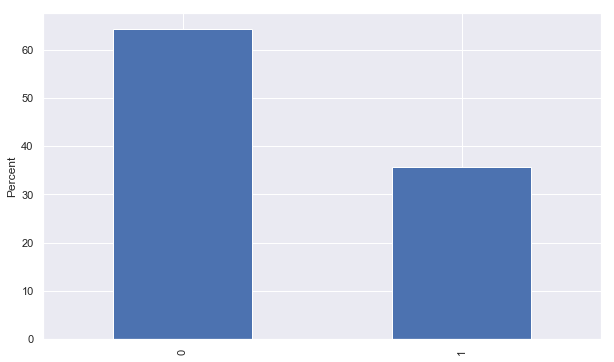

In [283]:
#Plotting out the percentages of the counts
# 0 represents no purchase
# 1 represents purchase
plt.figure(figsize=(10,6))
ax = (pd.Series(comments_df['Purchase']).value_counts(normalize=True, sort=False)*100).plot.bar()
ax.set(ylabel="Percent")
plt.show()

In [284]:
#Perform a count to get the number of comments per user
# Can the number of comments made by a user dictate whether or not a purchase will be made?

#Use Counter to calculate the number of comments per user
from collections import Counter
users = Counter([item for item in comments_df['User_ID']])
user_count = pd.DataFrame(users.most_common(15))
user_count.columns = ['User_ID','count']

#A function to extract the purchase status and merge with the no of comments per user dataframe
def get_purchase_status():
    purchase_batch = comments_df.drop_duplicates(['User_ID'])
    drop_cols = ['Comment_ID','Date','Likes','Comment']
    purchase_batch = purchase_batch.drop(drop_cols, axis = 1)
    
    return purchase_batch
            
merging_df= get_purchase_status()
merged_df = pd.merge(user_count,merging_df, on ='User_ID', how = 'inner')

#Display the result
merged_df.style.background_gradient(cmap='Blues')

,User_ID,count,Purchase
0,USID031,3,0
1,USID021,3,1
2,USID033,3,1
3,USID032,3,1
4,USID007,2,0
5,USID010,2,0
6,USID016,2,1
7,USID002,2,0
8,USID004,2,1
9,USID014,2,0


#### i)Text Cleaning

In [285]:
# Create a new dataframe 'data' to store the changes to our dataset.
data = comments_df
data.head(5)

,Comment_ID,User_ID,Date,Likes,Comment,Purchase
0,1,USID005,13/04/20 08:24:59,0,This too?,0
1,2,USID026,13/04/20 17:13:14,0,How mcih,0
2,3,USID031,13/04/20 08:05:29,1,How much is the belt ?,0
3,4,USID022,16/04/20 12:14:54,0,Is this still available?,1
4,5,USID021,16/04/20 13:19:23,0,@user hey... the belt,1


In [286]:
# Initialize empty array 
# to append clean text  
corpus = []  

In [287]:
# 87 (comments) rows to clean 
for i in range(0, 87):  
      
    # column : "Review", row ith 
    comment = re.sub('[^a-zA-Z]', ' ', data['Comment'][i])  
      
    # convert all cases to lower cases 
    comment = comment.lower()  
      
    # split to array(default delimiter is " ") 
    comment = comment.split()  
      
    # creating PorterStemmer object to 
    # take main stem of each word 
    ps = PorterStemmer()  
      
    # loop for stemming each word 
    # in string array at ith row     
    comment = [ps.stem(word) for word in comment 
                if not word in set(stopwords.words('english'))]  
                  
    # rejoin all string array elements 
    # to create back into a string 
    comment = ' '.join(comment)   
    
    # append each string to create 
    # array of clean text  
    corpus.append(comment)

In [288]:
#Create a new column 'selected_text' in the data dataframe and append corpus to it 
data['selected_text'] = corpus
data.head(5)

,Comment_ID,User_ID,Date,Likes,Comment,Purchase,selected_text
0,1,USID005,13/04/20 08:24:59,0,This too?,0,
1,2,USID026,13/04/20 17:13:14,0,How mcih,0,mcih
2,3,USID031,13/04/20 08:05:29,1,How much is the belt ?,0,much belt
3,4,USID022,16/04/20 12:14:54,0,Is this still available?,1,still avail
4,5,USID021,16/04/20 13:19:23,0,@user hey... the belt,1,user hey belt


#### Data Visualization

In [289]:
#Visualize the words and Phrase through WordCloud.
# Let's see the commonly used for both purchase and no purchase

In [290]:
def plotWordClouds(df_text,sentiment):
    text = " ".join(str(tmptext) for tmptext in df_text)
    text = text.lower()
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(text)
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('WordCloud - ' + sentiment)
    plt.show()     

In [291]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

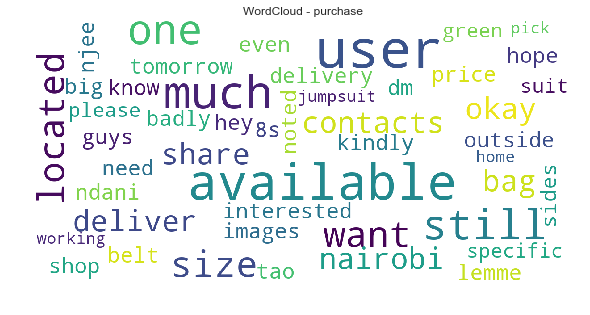

In [292]:
# Visualizing the commonly used words for Purchase
subtext = data[data['Purchase']==1]['Comment']
plotWordClouds(subtext,'purchase')

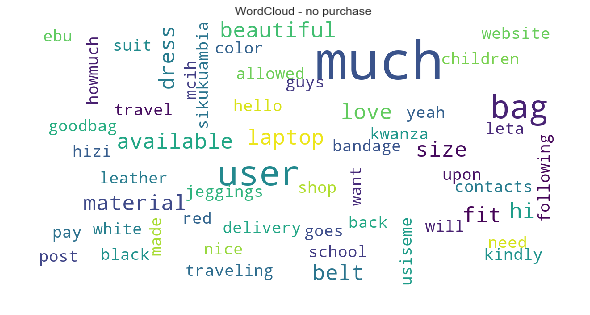

In [293]:
#Visualizing the commonly used words for no purchase
subtext = data[data['Purchase']==0]['Comment']
plotWordClouds(subtext,'no purchase')

In [294]:
# Words with their frequency with descending order
data['temp_list'] = data['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in data['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(15))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,much,27
1,user,14
2,avail,8
3,bag,8
4,size,5
5,still,4
6,want,4
7,get,4
8,one,4
9,belt,3


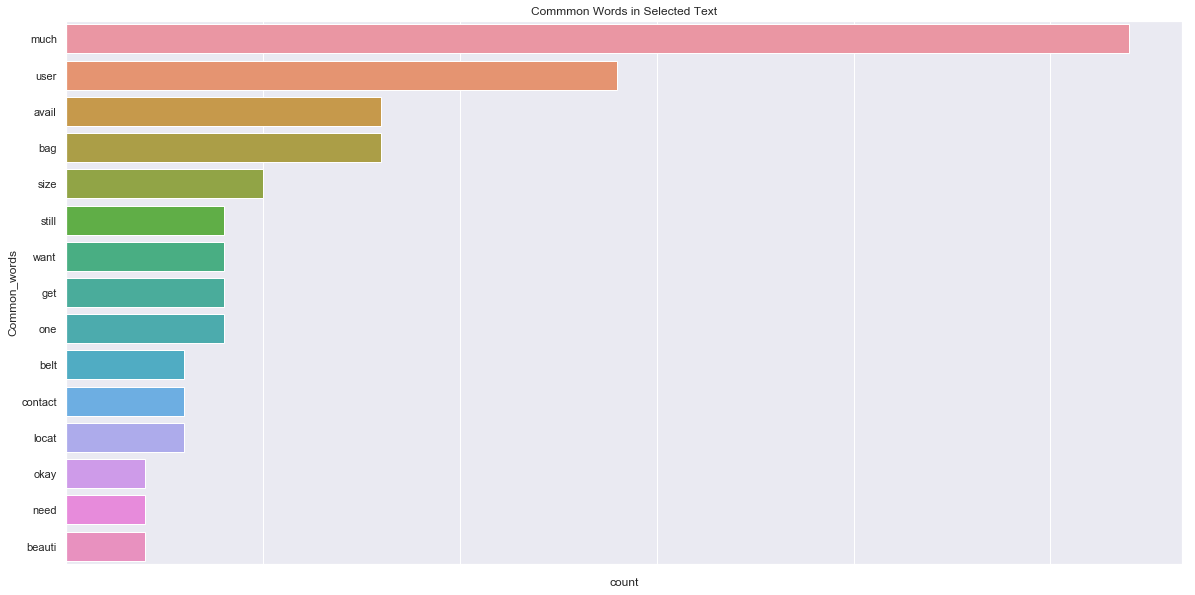

In [295]:
# Graphical representation of the word frequency
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] =10
plt.rcParams["figure.figsize"] = fig_size

sns.set(style='darkgrid')
plt.title('Commmon Words in Selected Text')
chart_1=sns.barplot(x="count",y="Common_words", data=temp)

chart_1.set_xticklabels(chart_1.get_xticklabels(), rotation=45, horizontalalignment='right')
chart_1

#### Text Processing

In [310]:
#Drop the unnecessary columns 
cols = ['Comment_ID','User_ID','Date','Likes','Comment','temp_list']
data = data.drop(cols, axis = 1)
data.sample(5)

,Purchase,selected_text
23,1,could guy even share contact need bag know sho...
57,1,much
53,0,much
10,0,avail
83,0,black white


In [311]:
# Creating the Bag of Words model 
#from sklearn.feature_extraction.text import CountVectorizer 
  
# To extract max 1500 feature. 
# "max_features" is attribute to 
# experiment with to get better results 
cv = CountVectorizer(max_features = 1500)  
  
# X contains corpus (dependent variable) 
X = cv.fit_transform(corpus).toarray()  
  
# y contains answers if review 
# is positive or negative 
y = data.iloc[:, 0].values  

In [394]:
# Split the data into train and test data in preparation for modelling 
# We will split the data 80/20 i.e 80 training data and 20 testing data
# Splitting the dataset into 
# the Training set and Test set 
from sklearn.model_selection import train_test_split 
  
# experiment with "test_size" 
# to get better results 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30) 

### Modelling

#### Random Forest

In [395]:
# Fitting Random Forest Classification 
# to the Training set 
from sklearn.ensemble import RandomForestClassifier 
  
# n_estimators can be said as number of 
# trees, experiment with n_estimators 
# to get better results  
model = RandomForestClassifier(n_estimators = 501, 
                            criterion = 'entropy') 
                              
model.fit(X_train, y_train)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [396]:
# Predicting the Test set results 
random_forest_pred = model.predict(X_test) 
  
random_forest_pred 

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0], dtype=int64)

In [397]:
print("Accuracy: ",metrics.accuracy_score(y_test, random_forest_pred))

Accuracy:  0.7407407407407407


In [398]:
print(classification_report(y_test, random_forest_pred))

              precision    recall  f1-score   support

           0       0.74      0.94      0.83        18
           1       0.75      0.33      0.46         9

   micro avg       0.74      0.74      0.74        27
   macro avg       0.74      0.64      0.65        27
weighted avg       0.74      0.74      0.71        27



In [399]:
random_forest_confusion_matrix = confusion_matrix(y_test, random_forest_pred)
print(random_forest_confusion_matrix)

[[17  1]
 [ 6  3]]


#### Logistic Regression

In [400]:
# Imort Linear Model
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

In [401]:
# Fit (train) the Logistic Regression classifier
#Using sklearn
sklearn_logistic_regression_model = LogisticRegression()
sklearn_logistic_regression_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [402]:
logistic_regression_pred = sklearn_logistic_regression_model.predict(X_test)
logistic_regression_pred 

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0], dtype=int64)

In [403]:
print("Accuracy: " ,metrics.accuracy_score(y_test, logistic_regression_pred))

Accuracy:  0.7037037037037037


In [404]:
print(classification_report(y_test, logistic_regression_pred))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80        18
           1       0.60      0.33      0.43         9

   micro avg       0.70      0.70      0.70        27
   macro avg       0.66      0.61      0.61        27
weighted avg       0.68      0.70      0.68        27



In [405]:
logistic_regression_confusion_matrix = confusion_matrix(y_test, logistic_regression_pred)
print(logistic_regression_confusion_matrix)

[[16  2]
 [ 6  3]]


#### Model Evaluation 

##### The random forest model:
Accuracy: **74%**

Confusion matrix: False negatives of **6**

Our target variable has a precision of **0.75**

Our target variable has a recall of **0.33**

##### The logistic regression model:
Accuracy: **70.4%**

Confusion matrix: False negatives of **6**

Our target variable has a precision of **0.60**

Our target variable has a recall of **0.33**